We want to find out whether probabilistically adding a measurement header to some of the packets is able to perform more efficiently than using a single bit.

In this notebook, we extract TCP flows of a trace and store it as hdf5 for later processing using `libtrace` and `pandas`. 

##### Getting trace for testing
1. Download a trace from [MAWI Traffic Archive](http://mawi.wide.ad.jp/mawi/). This notebook uses a trace from [June 14th, 2018](http://mawi.wide.ad.jp/mawi/samplepoint-F/2018/201806141400.html).
2. Trucate to a workable time duration (e.g. 10 seconds) with [tracesplit](https://github.com/LibtraceTeam/libtrace/wiki/tracesplit): `tracesplit -i 10 -m 1 inputuri outputuri`

In [ ]:
TRACE_PATH = '/tmp/trace.pcap'
STORE_PATH = '/tmp/flows.hdf5'

In [ ]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import plt as libtrace
import sys
sys.path.append('src')

from managed_trace import managed_trace
from tcp_packet import try_read_tcp_packet, TCPPacket

We read from the trace, filtering TCP packets, and store the relevant fields of the packets in a list of namedtuples.

In [ ]:
filter_ = libtrace.filter('tcp')
with managed_trace(TRACE_PATH) as trace:
    trace.conf_filter(filter_)
    tcp_packets_with_nones = [try_read_tcp_packet(packet) for packet in trace]
tcp_packets = [p for p in tcp_packets_with_nones if p is not None]
nones_percentage = (len(tcp_packets_with_nones) - len(tcp_packets)) / len(tcp_packets_with_nones) * 100
print('Could not read {:.2f}% of packets'.format(nones_percentage))
tcp_df = pd.DataFrame.from_records(tcp_packets, columns=TCPPacket._fields)

Could not read 0.06% of packets


Now we have a `dataframe` with the following columns:

In [ ]:
list(tcp_df)

['timestamp',
 'flow_hash',
 'direction',
 'seq_nr',
 'ack_nr',
 'flags',
 'ts_val',
 'ts_ecr',
 'payload_length']

Most of the flows are very short:

In [ ]:
tcp_df['flow_hash'].value_counts().quantile(0.75)

1.0

So, we remove all the flows that are shorter than 3.

In [ ]:
flow_lengths = tcp_df['flow_hash'].value_counts()
flows_to_keep = set(flow_lengths[flow_lengths >= 3].index.values)
indices_to_keep = tcp_df.index[tcp_df['flow_hash'].apply(lambda h: h in flows_to_keep)].tolist()
tcp_df = tcp_df.take(list(indices_to_keep))
tcp_df['flow_hash'].value_counts().quantile(0.75)

19.0

In [ ]:
with pd.HDFStore(STORE_PATH) as store:
    store['tcp_df'] = tcp_df

## Stats

In [ ]:
packet_counts = tcp_df['flow_hash'].value_counts()
print(f'Number of packets: {len(tcp_df)}')
print(f'Number of flows: {len(packet_counts)}')

Number of packets: 948626
Number of flows: 9736


Most of the flows are very short, but the tail is heavy:

In [ ]:
packet_counts.describe()

count     9736.000000
mean        97.434881
std        684.168697
min          3.000000
25%          5.000000
50%          9.000000
75%         19.000000
max      29245.000000
Name: flow_hash, dtype: float64

50% of flows longer than 3 packets have at most 8 packets. To enable an
on-path observer to collect a single RTT sample requires adding a header to at
least three packets. The measurement header for RTT measurement carries two
timestamps ($t_{now}$, $t_{echo}$). Even if the timestamps are taken relative to
the beginning of the flow and each use fewer, say, 16 bits, the effective number
of this bits per packet for a flow of 8 packets would be 16. Thus, the spin bit
\- if it achieves similar accuracy - is more efficient in the common case.

This is the distribution of flow lenghts, considering only flows between 3 and 100 packets:

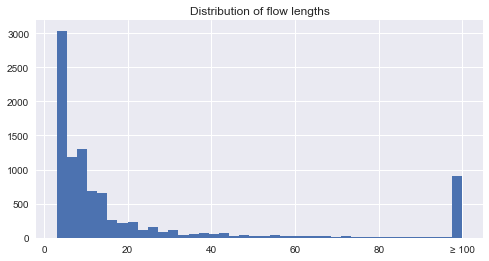

In [ ]:
from itertools import chain
ax = packet_counts.clip(0, 100).hist(bins=40, figsize=(8,4))
ax.set_title('Distribution of flow lengths')
_ = ax.set_xticklabels(chain.from_iterable([range(-20, 90, 20), ['≥ 100']]))

The ratio of the values above 100 is

In [ ]:
len(packet_counts[packet_counts >= 100]) / len(packet_counts)

Let's consider the payload lengths: They have been set to zero in the MAWI traces. If this were not the case, we could discriminate between zero and nonzero payloads and only consider `TSval`s from nonzero payloads, which would prevent getting RTTs that correspond to breaks in communication.

In [ ]:
tcp_df['payload_length'].value_counts()

0    948626
Name: payload_length, dtype: int64